# MPC Weight Tuning with Bayesian Optimization

This notebook uses Optuna for Bayesian optimization to tune MPC economic weights.

**Goal**: Find MPC weights that maximize revenue (evaluated using GA's economic metric)

**Approach**: Bilevel optimization where:
- Outer loop: Optuna searches over MPC weight parameters
- Inner loop: MPC simulation evaluates each weight configuration

In [37]:
# Import necessary modules
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import warnings

import optuna

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.mpc.mpc import MPC
from core.mpc.mpc_params import MPCParams
from core.mpc.mpc_bounds import ControlInputBounds

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.ga.ga_params import GeneticAlgorithmParams

from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

from core.bo import BOParams, BayesianOptimization, BOPlotting
from core.bo.bo import BOResult
from core.bo.bo_params import MPCWeightSearchSpace

# Apply plotting style
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

# Suppress solver output
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. Model Parameters

Same parameters as the weather scenario experiments for consistency.

In [38]:
# Model parameters (hourly time stepping for MPC)
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = False,
    verbose          = False
)

# Carrying capacities (corn defaults)
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

# Growth rates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

# Sensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

# Initial conditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours,
    A0=carrying_capacities.kA/model_params.simulation_hours,
    N0=carrying_capacities.kN/model_params.simulation_hours,
    c0=carrying_capacities.kc/model_params.simulation_hours,
    P0=carrying_capacities.kP/model_params.simulation_hours
)

# Typical disturbances
default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

# Control bounds
bounds = ControlInputBounds()

print("Model parameters configured.")

Model parameters configured.


## 2. Load Weather Data

In [39]:
# Load baseline weather data
weather_path = "../../io/inputs/hourly_prcp_rad_temp_iowa.csv"
weather_df = pd.read_csv(weather_path)

# Create disturbances
baseline_disturbances = ModelDisturbances(
    precipitation = weather_df['Hourly Precipitation (in)'].to_numpy(),
    radiation     = weather_df['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = weather_df['Temperature (C)'].to_numpy()
)

print(f"Loaded weather data: {len(weather_df)} hours")
print(f"  Temperature range: {weather_df['Temperature (C)'].min():.1f} to {weather_df['Temperature (C)'].max():.1f} °C")
print(f"  Total precipitation: {weather_df['Hourly Precipitation (in)'].sum():.1f} inches")

Loaded weather data: 2928 hours
  Temperature range: 8.7 to 35.0 °C
  Total precipitation: 31.5 inches


## 3. GA Economic Weights (for Evaluation)

MPC revenue is evaluated using GA's economic weights for fair comparison.

In [40]:
# Get GA economic weights (used for revenue evaluation, NOT MPC objective)
ga_params = GeneticAlgorithmParams()

# These are fixed - used to evaluate the revenue after MPC runs
EVAL_WEIGHT_FRUIT_BIOMASS = ga_params.weight_fruit_biomass  # 4450 $/kg-plant
EVAL_WEIGHT_HEIGHT = ga_params.weight_height                # 35 $/m-plant
EVAL_WEIGHT_LEAF_AREA = ga_params.weight_leaf_area          # 215 $/m2-plant
EVAL_WEIGHT_IRRIGATION = ga_params.weight_irrigation        # 2.0 $/acre-inch
EVAL_WEIGHT_FERTILIZER = ga_params.weight_fertilizer        # 0.614 $/lb-acre

print("GA Economic Weights (for evaluation):")
print(f"  Fruit biomass: ${EVAL_WEIGHT_FRUIT_BIOMASS}/kg-plant")
print(f"  Height:        ${EVAL_WEIGHT_HEIGHT}/m-plant")
print(f"  Leaf area:     ${EVAL_WEIGHT_LEAF_AREA}/m²-plant")
print(f"  Irrigation:    ${EVAL_WEIGHT_IRRIGATION}/acre-inch")
print(f"  Fertilizer:    ${EVAL_WEIGHT_FERTILIZER}/lb-acre")

GA Economic Weights (for evaluation):
  Fruit biomass: $4450/kg-plant
  Height:        $35.0/m-plant
  Leaf area:     $215.0/m²-plant
  Irrigation:    $2.0/acre-inch
  Fertilizer:    $0.614/lb-acre


In [41]:
def compute_revenue(mpc_result: dict) -> float:
    """
    Compute economic revenue using GA weights (for fair comparison).
    
    Revenue = (biomass value + height value + leaf area value) - (irrigation cost + fertilizer cost)
    """
    P_final = mpc_result["P"][-1]
    h_final = mpc_result["h"][-1]
    A_final = mpc_result["A"][-1]
    total_irrigation = np.sum(mpc_result["irrigation"])
    total_fertilizer = np.sum(mpc_result["fertilizer"])
    
    profit = (
        EVAL_WEIGHT_FRUIT_BIOMASS * P_final +
        EVAL_WEIGHT_HEIGHT * h_final +
        EVAL_WEIGHT_LEAF_AREA * A_final
    )
    expenses = (
        EVAL_WEIGHT_IRRIGATION * total_irrigation +
        EVAL_WEIGHT_FERTILIZER * total_fertilizer
    )
    
    return profit - expenses

## 4. Objective Function Factory

Creates an Optuna objective that evaluates MPC with given weights.

In [42]:
def create_mpc_objective(disturbances: ModelDisturbances, bo_params: BOParams):
    """
    Factory function to create an Optuna objective with fixed disturbances.
    Uses BOParams to define the search space.
    """
    
    def objective(trial: optuna.Trial) -> float:
        # Suggest parameters from search space
        params = {}
        for name, (low, high, log_scale) in bo_params.search_space.items():
            params[name] = trial.suggest_float(name, low, high, log=log_scale)
        for name, (low, high) in bo_params.integer_params.items():
            params[name] = trial.suggest_int(name, low, high)
        
        # Create MPC params
        mpc_params = MPCParams(
            daily_horizon           = params.get('daily_horizon', 7),
            weight_irrigation       = params['weight_irrigation'],
            weight_fertilizer       = params['weight_fertilizer'],
            weight_height           = params['weight_height'],
            weight_leaf_area        = params['weight_leaf_area'],
            weight_fruit_biomass    = params['weight_fruit_biomass'],
            weight_water_anomaly    = params['weight_water_anomaly'],
            weight_fertilizer_anomaly = params['weight_fertilizer_anomaly'],
            solver                  = "ipopt",
            solver_options          = {
                "tol": 1e-4,
                "acceptable_iter": 100,
                "max_iter": 500,
                "print_level": 0,
                "mu_strategy": "adaptive",
                "linear_solver": "mumps",
            }
        )
        
        # Run MPC
        mpc = MPC(
            carrying_capacities  = carrying_capacities,
            disturbances         = disturbances,
            growth_rates         = growth_rates,
            initial_conditions   = initial_conditions,
            model_params         = model_params,
            typical_disturbances = typical_disturbances,
            sensitivities        = sensitivities,
            mpc_params           = mpc_params,
            bounds               = bounds
        )
        
        try:
            result = mpc.run()
            revenue = compute_revenue(result)
            
            # Store auxiliary metrics
            trial.set_user_attr('fruit_biomass', result["P"][-1])
            trial.set_user_attr('height', result["h"][-1])
            trial.set_user_attr('leaf_area', result["A"][-1])
            trial.set_user_attr('total_irrigation', np.sum(result["irrigation"]))
            trial.set_user_attr('total_fertilizer', np.sum(result["fertilizer"]))
            
            return revenue
            
        except Exception as e:
            trial.set_user_attr('error', str(e))
            return -1000.0
    
    return objective

print("Objective function factory defined.")

Objective function factory defined.


## 5. Run Bayesian Optimization

This cell is commented out - results are loaded from pickle files below.

In [43]:
'''
# Get default search space for MPC weight tuning
bo_params = MPCWeightSearchSpace.get_default()

# Create BO instance
bo = BayesianOptimization(bo_params)

# Create objective
objective = create_mpc_objective(baseline_disturbances, bo_params)

# Run optimization
result = bo.run(objective, show_progress=True, verbose=True)

# Save results
result.save('tuning_results', prefix='bo')
print("Results saved!")
'''

'\n# Get default search space for MPC weight tuning\nbo_params = MPCWeightSearchSpace.get_default()\n\n# Create BO instance\nbo = BayesianOptimization(bo_params)\n\n# Create objective\nobjective = create_mpc_objective(baseline_disturbances, bo_params)\n\n# Run optimization\nresult = bo.run(objective, show_progress=True, verbose=True)\n\n# Save results\nresult.save(\'tuning_results\', prefix=\'bo\')\nprint("Results saved!")\n'

In [44]:
# Load saved results (directly from existing pickle file)
import pickle

bo_params = MPCWeightSearchSpace.get_default()

with open('tuning_results/optuna_study.pkl', 'rb') as f:
    study = pickle.load(f)

# Construct BOResult from the loaded study
result = BOResult(
    study=study,
    best_value=study.best_value,
    best_params=study.best_params,
    best_trial=study.best_trial,
    n_trials=len(study.trials),
    elapsed_time=0.0,  # Not stored in original pickle
    bo_params=bo_params
)

print(f"Loaded study with {result.n_trials} trials")
print(f"Best revenue: ${result.best_value:.2f}")

Loaded study with 100 trials
Best revenue: $1027.10


## 6. Results Analysis

In [45]:
# Best parameters
print("=" * 60)
print("BEST PARAMETERS FOUND")
print("=" * 60)
print(f"\nBest Revenue: ${result.best_value:.2f}")
print(f"\nOptimal MPC Weights:")
for param, value in result.best_params.items():
    if 'weight' in param:
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

# Best trial additional metrics
best_trial = result.best_trial
print(f"\nBest Trial Outcomes:")
print(f"  Fruit biomass:    {best_trial.user_attrs.get('fruit_biomass', 'N/A'):.4f} kg")
print(f"  Height:           {best_trial.user_attrs.get('height', 'N/A'):.4f} m")
print(f"  Leaf area:        {best_trial.user_attrs.get('leaf_area', 'N/A'):.4f} m²")
print(f"  Total irrigation: {best_trial.user_attrs.get('total_irrigation', 'N/A'):.2f} inches")
print(f"  Total fertilizer: {best_trial.user_attrs.get('total_fertilizer', 'N/A'):.2f} lbs")

BEST PARAMETERS FOUND

Best Revenue: $1027.10

Optimal MPC Weights:
  weight_irrigation: 0.464136
  weight_fertilizer: 0.000967
  weight_height: 761.026243
  weight_leaf_area: 454.645905
  weight_fruit_biomass: 1075.029016
  weight_water_anomaly: 0.006421
  weight_fertilizer_anomaly: 0.007810
  daily_horizon: 3

Best Trial Outcomes:
  Fruit biomass:    0.2269 kg
  Height:           2.7538 m
  Leaf area:        0.5955 m²
  Total irrigation: 0.65 inches
  Total fertilizer: 334.91 lbs


In [46]:
# Top trials
trials_df = result.get_sorted_trials(ascending=False)

print("Top 10 Trials:")
display_cols = ['number', 'value', 'params_weight_irrigation', 'params_weight_fertilizer', 
                'params_weight_fruit_biomass', 'params_daily_horizon']
available_cols = [c for c in display_cols if c in trials_df.columns]
print(trials_df[available_cols].head(10).to_string())

Top 10 Trials:
    number        value  params_weight_irrigation  params_weight_fertilizer  params_weight_fruit_biomass  params_daily_horizon
91      91  1027.099076                  0.464136                  0.000967                  1075.029016                     3
97      97  1022.505094                  0.216126                  0.000645                   163.891150                     4
78      78  1020.432939                  1.000830                  0.001704                  2991.317168                     5
92      92  1017.833368                  0.487009                  0.000978                   855.828759                     3
96      96  1016.885119                  1.193854                  0.000636                   181.881719                     4
85      85  1015.437578                  0.483693                  0.000952                  1343.658251                     3
84      84  1012.166629                  0.486840                  0.000983                  156

## 7. Visualizations

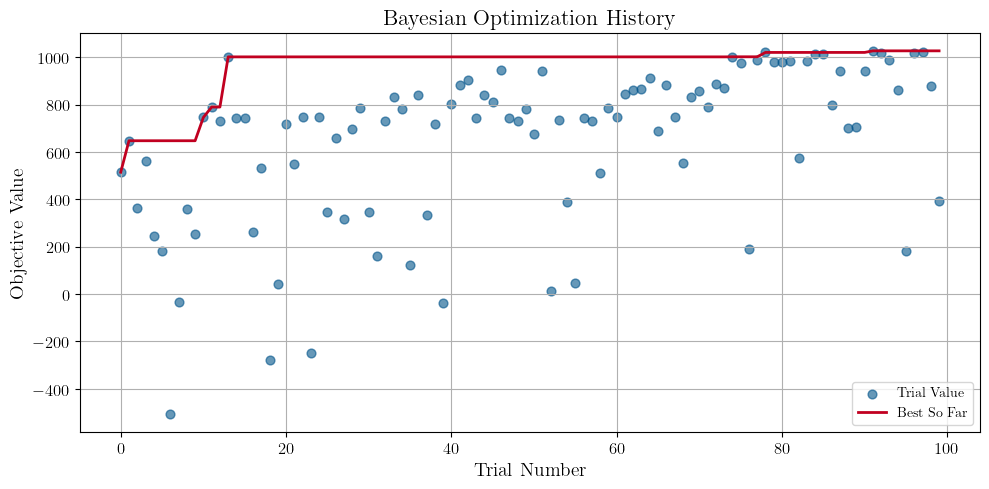

In [47]:
# Create BOPlotting instance
bo_plotting = BOPlotting(result, colors=plotting_colors)

# Optimization history
fig = bo_plotting.plot_optimization_history()
plt.tight_layout()
plt.savefig('tuning_results/optimization_history.png', dpi=150, bbox_inches='tight')
plt.show()

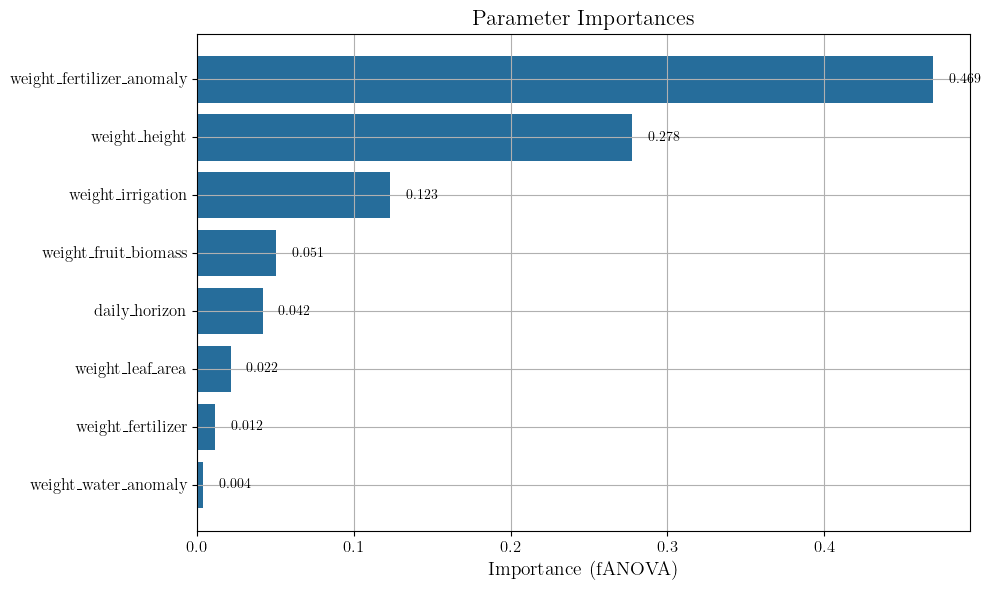

In [48]:
# Parameter importances
fig = bo_plotting.plot_param_importances()
plt.tight_layout()
plt.savefig('tuning_results/param_importances.png', dpi=150, bbox_inches='tight')
plt.show()

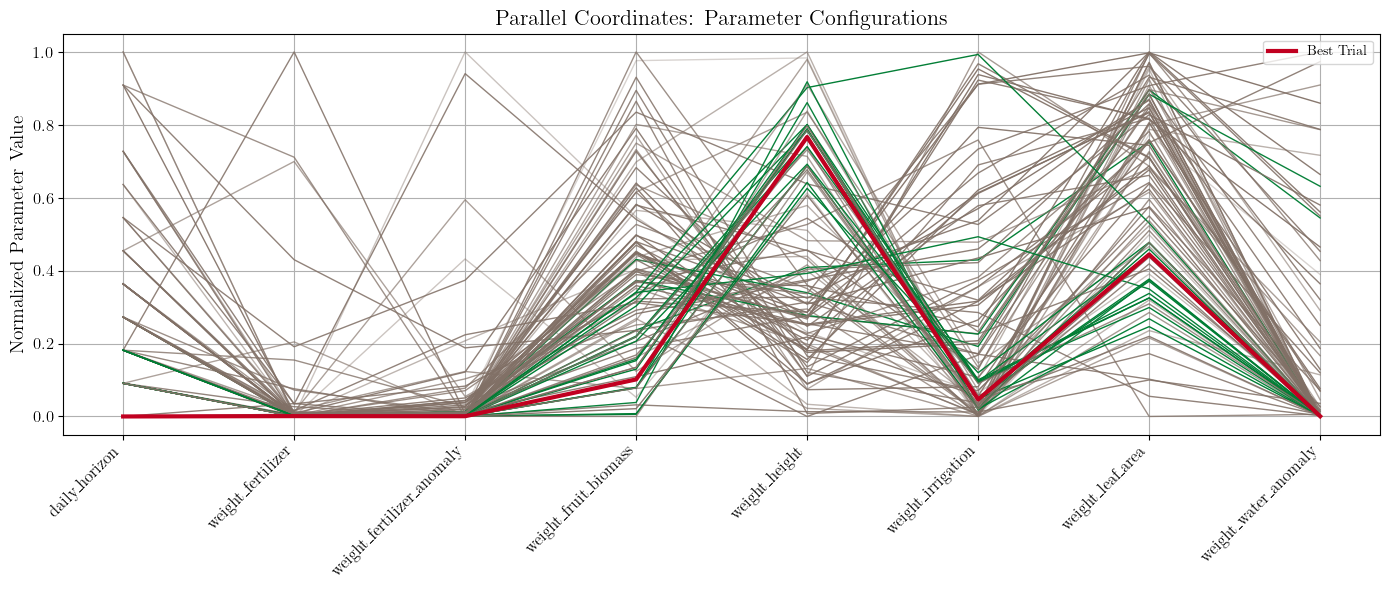

In [49]:
# Parallel coordinates
fig = bo_plotting.plot_parallel_coordinates()
plt.tight_layout()
plt.savefig('tuning_results/parallel_coordinates.png', dpi=150, bbox_inches='tight')
plt.show()

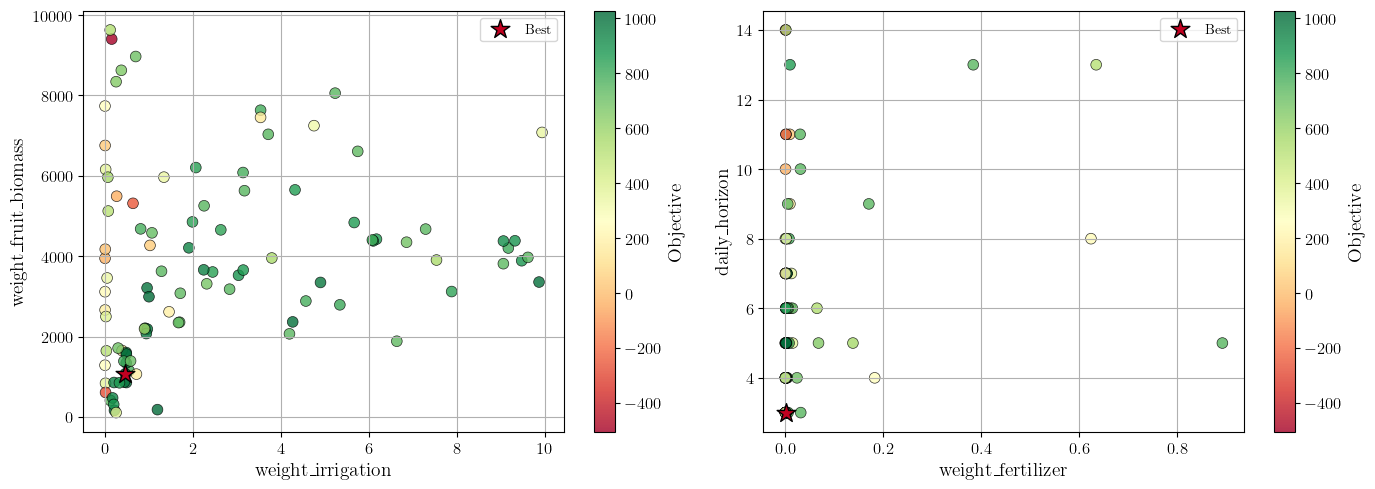

In [50]:
# Parameter scatter plots
param_pairs = [
    ('weight_irrigation', 'weight_fruit_biomass'),
    ('weight_fertilizer', 'daily_horizon')
]
fig = bo_plotting.plot_parameter_scatter(param_pairs)
plt.tight_layout()
plt.savefig('tuning_results/parameter_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Compare Best MPC with Default and GA

In [51]:
# Run MPC with default weights for comparison
default_mpc_params = MPCParams(
    daily_horizon   = 7,
    solver          = "ipopt",
    solver_options  = {
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }
)

print("Running MPC with DEFAULT weights...")
mpc_default = MPC(
    carrying_capacities  = carrying_capacities,
    disturbances         = baseline_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    mpc_params           = default_mpc_params,
    bounds               = bounds
)
result_default = mpc_default.run()
revenue_default = compute_revenue(result_default)
print(f"  Revenue: ${revenue_default:.2f}")

# Run MPC with tuned weights
print("\nRunning MPC with TUNED weights...")
tuned_mpc_params = MPCParams(
    daily_horizon           = result.best_params['daily_horizon'],
    weight_irrigation       = result.best_params['weight_irrigation'],
    weight_fertilizer       = result.best_params['weight_fertilizer'],
    weight_height           = result.best_params['weight_height'],
    weight_leaf_area        = result.best_params['weight_leaf_area'],
    weight_fruit_biomass    = result.best_params['weight_fruit_biomass'],
    weight_water_anomaly    = result.best_params['weight_water_anomaly'],
    weight_fertilizer_anomaly = result.best_params['weight_fertilizer_anomaly'],
    solver                  = "ipopt",
    solver_options          = {
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }
)
mpc_tuned = MPC(
    carrying_capacities  = carrying_capacities,
    disturbances         = baseline_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    mpc_params           = tuned_mpc_params,
    bounds               = bounds
)
result_tuned = mpc_tuned.run()
revenue_tuned = compute_revenue(result_tuned)
print(f"  Revenue: ${revenue_tuned:.2f}")

Running MPC with DEFAULT weights...
[Daily MPC] Day 1/120, hour index 0
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 2/120, hour index 24
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 3/120, hour index 48
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 4/120, hour index 72
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 5/120, hour index 96
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 6/120, hour index 120
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 7/120, hour index 144
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 8/120, hour index 168
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 9/120, hour index 192
[CFTOC] Solver status: warning, termination: maxIterations
[CFTOC] WARNING: bad solver status, using fallback control plan.
[Daily MPC] Day 10/120, hour index 216
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 11/120, hour inde

In [52]:
# Summary comparison
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

ga_baseline = 1024.46  # GA baseline revenue

print(f"\n{'Method':<25} {'Revenue':>12} {'vs GA':>10}")
print("-" * 50)
print(f"{'GA (fixed strategy)':<25} ${ga_baseline:>10.2f} {'—':>10}")
print(f"{'MPC (default weights)':<25} ${revenue_default:>10.2f} {(revenue_default - ga_baseline)/ga_baseline*100:>9.1f}%")
print(f"{'MPC (tuned weights)':<25} ${revenue_tuned:>10.2f} {(revenue_tuned - ga_baseline)/ga_baseline*100:>9.1f}%")
print("-" * 50)
print(f"{'Improvement from tuning':<25} ${revenue_tuned - revenue_default:>10.2f} {(revenue_tuned - revenue_default)/revenue_default*100:>9.1f}%")


PERFORMANCE COMPARISON

Method                         Revenue      vs GA
--------------------------------------------------
GA (fixed strategy)       $   1024.46          —
MPC (default weights)     $    916.47     -10.5%
MPC (tuned weights)       $   1027.10       0.3%
--------------------------------------------------
Improvement from tuning   $    110.63      12.1%


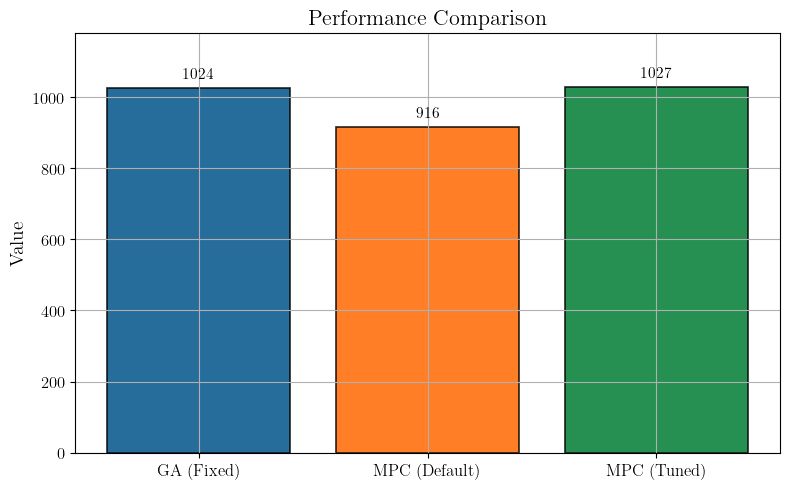

In [53]:
# Performance comparison bar chart
comparison_data = {
    'GA (Fixed)': ga_baseline,
    'MPC (Default)': revenue_default,
    'MPC (Tuned)': revenue_tuned
}

fig = bo_plotting.plot_comparison_bar(comparison_data)
plt.tight_layout()
plt.savefig('tuning_results/performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Code Snippet

In [54]:
# Print code snippet for using the tuned weights
print("\n" + "=" * 60)
print("CODE SNIPPET: Use these tuned weights in your MPC")
print("=" * 60)
print(f"""
mpc_params = MPCParams(
    daily_horizon           = {result.best_params['daily_horizon']},
    weight_irrigation       = {result.best_params['weight_irrigation']:.6f},
    weight_fertilizer       = {result.best_params['weight_fertilizer']:.6f},
    weight_height           = {result.best_params['weight_height']:.2f},
    weight_leaf_area        = {result.best_params['weight_leaf_area']:.2f},
    weight_fruit_biomass    = {result.best_params['weight_fruit_biomass']:.2f},
    weight_water_anomaly    = {result.best_params['weight_water_anomaly']:.6f},
    weight_fertilizer_anomaly = {result.best_params['weight_fertilizer_anomaly']:.6f},
    solver                  = "ipopt",
    solver_options          = {{
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }}
)
""")


CODE SNIPPET: Use these tuned weights in your MPC

mpc_params = MPCParams(
    daily_horizon           = 3,
    weight_irrigation       = 0.464136,
    weight_fertilizer       = 0.000967,
    weight_height           = 761.03,
    weight_leaf_area        = 454.65,
    weight_fruit_biomass    = 1075.03,
    weight_water_anomaly    = 0.006421,
    weight_fertilizer_anomaly = 0.007810,
    solver                  = "ipopt",
    solver_options          = {
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }
)



## 10. (Optional) Multi-Scenario Robust Tuning

For weights that work well across different weather conditions (normal, drought, wet, extreme), optimize over multiple scenarios simultaneously.

In [55]:
# Generate weather scenarios for robust tuning
from core.weather.stochastic_weather import StochasticWeatherGenerator, get_default_scenarios

# Create generator from baseline weather
generator = StochasticWeatherGenerator(weather_df, seed=42)
all_scenarios = get_default_scenarios()

# Use 5 representative scenarios
selected_names = ['normal_1', 'moderate_dry', 'summer_drought', 'wet_year', 'extreme_drought_heat']
selected_scenarios = [s for s in all_scenarios if s.name in selected_names]

# Generate weather for selected scenarios
scenario_weather = {s.name: generator.generate(s) for s in selected_scenarios}
scenario_disturbances = {}
for name, df in scenario_weather.items():
    scenario_disturbances[name] = ModelDisturbances(
        precipitation = df['Hourly Precipitation (in)'].to_numpy(),
        radiation     = df['Hourly Radiation (W/m2)'].to_numpy(),
        temperature   = df['Temperature (C)'].to_numpy()
    )

print(f"Generated {len(scenario_disturbances)} scenarios for robust tuning:")
for name, scenario in zip(selected_names, selected_scenarios):
    print(f"  {name}: extremity={scenario.extremity_index():.2f}")

Generated 5 scenarios for robust tuning:
  normal_1: extremity=0.00
  moderate_dry: extremity=0.80
  summer_drought: extremity=1.70
  wet_year: extremity=1.10
  extreme_drought_heat: extremity=4.97


In [56]:
def create_multi_scenario_objective(scenario_disturbances: dict, bo_params: BOParams):
    """
    Factory for multi-scenario objective that averages revenue across scenarios.
    """
    
    def objective(trial: optuna.Trial) -> float:
        # Suggest parameters from search space
        params = {}
        for name, (low, high, log_scale) in bo_params.search_space.items():
            params[name] = trial.suggest_float(name, low, high, log=log_scale)
        for name, (low, high) in bo_params.integer_params.items():
            params[name] = trial.suggest_int(name, low, high)
        
        mpc_params = MPCParams(
            daily_horizon           = params.get('daily_horizon', 7),
            weight_irrigation       = params['weight_irrigation'],
            weight_fertilizer       = params['weight_fertilizer'],
            weight_height           = params['weight_height'],
            weight_leaf_area        = params['weight_leaf_area'],
            weight_fruit_biomass    = params['weight_fruit_biomass'],
            weight_water_anomaly    = params['weight_water_anomaly'],
            weight_fertilizer_anomaly = params['weight_fertilizer_anomaly'],
            solver                  = "ipopt",
            solver_options          = {"tol": 1e-4, "max_iter": 500, "print_level": 0}
        )
        
        # Run MPC on all scenarios
        revenues = []
        for name, disturbances in scenario_disturbances.items():
            try:
                mpc = MPC(
                    carrying_capacities  = carrying_capacities,
                    disturbances         = disturbances,
                    growth_rates         = growth_rates,
                    initial_conditions   = initial_conditions,
                    model_params         = model_params,
                    typical_disturbances = typical_disturbances,
                    sensitivities        = sensitivities,
                    mpc_params           = mpc_params,
                    bounds               = bounds
                )
                result = mpc.run()
                revenues.append(compute_revenue(result))
                trial.set_user_attr(f'revenue_{name}', revenues[-1])
            except Exception:
                revenues.append(-1000.0)
        
        return np.mean(revenues)
    
    return objective

print("Multi-scenario objective factory defined.")

Multi-scenario objective factory defined.


In [57]:
'''
# Run robust optimization
robust_bo_params = MPCWeightSearchSpace.get_robust()
bo_robust = BayesianOptimization(robust_bo_params)

robust_objective = create_multi_scenario_objective(scenario_disturbances, robust_bo_params)
result_robust = bo_robust.run(robust_objective, show_progress=True, verbose=True)

result_robust.save('tuning_results', prefix='robust')
print("Robust results saved!")
'''

'\n# Run robust optimization\nrobust_bo_params = MPCWeightSearchSpace.get_robust()\nbo_robust = BayesianOptimization(robust_bo_params)\n\nrobust_objective = create_multi_scenario_objective(scenario_disturbances, robust_bo_params)\nresult_robust = bo_robust.run(robust_objective, show_progress=True, verbose=True)\n\nresult_robust.save(\'tuning_results\', prefix=\'robust\')\nprint("Robust results saved!")\n'

In [58]:
# Load robust results (directly from existing pickle file)
robust_bo_params = MPCWeightSearchSpace.get_robust()

with open('tuning_results/optuna_study_robust.pkl', 'rb') as f:
    study_robust = pickle.load(f)

# Construct BOResult from the loaded study
result_robust = BOResult(
    study=study_robust,
    best_value=study_robust.best_value,
    best_params=study_robust.best_params,
    best_trial=study_robust.best_trial,
    n_trials=len(study_robust.trials),
    elapsed_time=0.0,
    bo_params=robust_bo_params
)

print(f"Loaded ROBUST study with {result_robust.n_trials} trials")
print(f"Best mean revenue: ${result_robust.best_value:.2f}")

Loaded ROBUST study with 50 trials
Best mean revenue: $886.47


In [59]:
# Robust optimization results
print("=" * 60)
print("ROBUST TUNING RESULTS (Multi-Scenario)")
print("=" * 60)
print(f"\nBest Mean Revenue: ${result_robust.best_value:.2f}")
print(f"\nOptimal Robust MPC Weights:")
for param, value in result_robust.best_params.items():
    if 'weight' in param:
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

# Per-scenario performance
print(f"\nPer-Scenario Revenue (Best Trial):")
best_robust_trial = result_robust.best_trial
for name in scenario_disturbances.keys():
    rev = best_robust_trial.user_attrs.get(f'revenue_{name}', 'N/A')
    if isinstance(rev, float):
        print(f"  {name}: ${rev:.2f}")
    else:
        print(f"  {name}: {rev}")

ROBUST TUNING RESULTS (Multi-Scenario)

Best Mean Revenue: $886.47

Optimal Robust MPC Weights:
  weight_irrigation: 0.176526
  weight_fertilizer: 0.002123
  weight_height: 590.824615
  weight_leaf_area: 490.983764
  weight_fruit_biomass: 1203.308271
  weight_water_anomaly: 2.938806
  weight_fertilizer_anomaly: 1.207217
  daily_horizon: 9

Per-Scenario Revenue (Best Trial):
  normal_1: $1016.79
  moderate_dry: $1058.90
  summer_drought: $977.14
  wet_year: $736.79
  extreme_drought_heat: $642.73


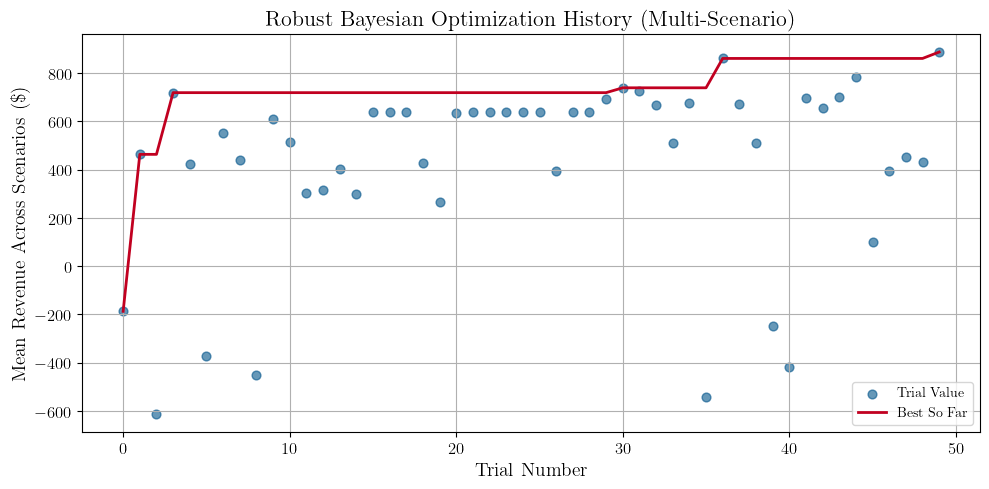

In [60]:
# Robust optimization history
bo_plotting_robust = BOPlotting(result_robust, colors=plotting_colors)

fig = bo_plotting_robust.plot_optimization_history()
plt.gca().set_ylabel('Mean Revenue Across Scenarios (\$)')
plt.gca().set_title('Robust Bayesian Optimization History (Multi-Scenario)')
plt.tight_layout()
plt.savefig('tuning_results/robust_optimization_history.png', dpi=150, bbox_inches='tight')
plt.show()

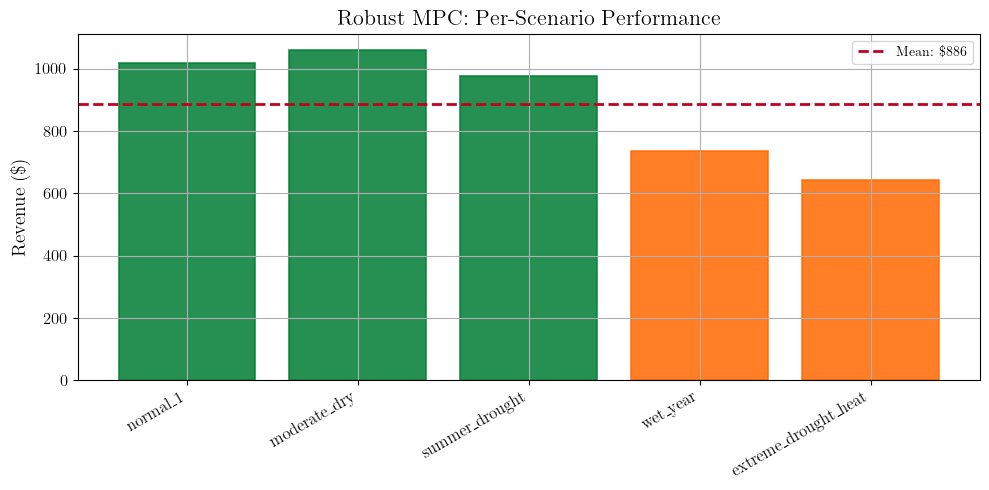

In [61]:
# Per-scenario revenue visualization
scenario_names = list(scenario_disturbances.keys())
robust_revenues = [best_robust_trial.user_attrs.get(f'revenue_{name}', 0) for name in scenario_names]

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(scenario_names))
bars = ax.bar(x, robust_revenues, color=plotting_colors.strong_blue, alpha=0.85, 
              edgecolor='black', linewidth=1.2)

# Add mean line
mean_rev = np.mean(robust_revenues)
ax.axhline(mean_rev, color=plotting_colors.vivid_red, linestyle='--', linewidth=2, 
           label=f'Mean: \${mean_rev:.0f}')

# Color bars by performance
for bar, rev in zip(bars, robust_revenues):
    if rev < mean_rev * 0.85:
        bar.set_color(plotting_colors.vivid_orange)
    elif rev > mean_rev * 1.1:
        bar.set_color(plotting_colors.vivid_green)

ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=30, ha='right')
ax.set_ylabel('Revenue (\$)')
ax.set_title('Robust MPC: Per-Scenario Performance')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('tuning_results/robust_scenario_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [62]:
# Print robust code snippet
print("\n" + "=" * 60)
print("CODE SNIPPET: Robust MPC weights (work across weather conditions)")
print("=" * 60)
print(f"""
mpc_params = MPCParams(
    daily_horizon           = {result_robust.best_params['daily_horizon']},
    weight_irrigation       = {result_robust.best_params['weight_irrigation']:.6f},
    weight_fertilizer       = {result_robust.best_params['weight_fertilizer']:.6f},
    weight_height           = {result_robust.best_params['weight_height']:.2f},
    weight_leaf_area        = {result_robust.best_params['weight_leaf_area']:.2f},
    weight_fruit_biomass    = {result_robust.best_params['weight_fruit_biomass']:.2f},
    weight_water_anomaly    = {result_robust.best_params['weight_water_anomaly']:.6f},
    weight_fertilizer_anomaly = {result_robust.best_params['weight_fertilizer_anomaly']:.6f},
    solver                  = "ipopt",
    solver_options          = {{
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }}
)
""")


CODE SNIPPET: Robust MPC weights (work across weather conditions)

mpc_params = MPCParams(
    daily_horizon           = 9,
    weight_irrigation       = 0.176526,
    weight_fertilizer       = 0.002123,
    weight_height           = 590.82,
    weight_leaf_area        = 490.98,
    weight_fruit_biomass    = 1203.31,
    weight_water_anomaly    = 2.938806,
    weight_fertilizer_anomaly = 1.207217,
    solver                  = "ipopt",
    solver_options          = {
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }
)

